# Writing Scientific Computations with Low Technical Debt

This example demonstrates an approach to writing a signal processing algorithm while developing minimal technical debt.  Debt represents software circumstances that slow or paralyze an engineering team maintaining, improving, and sharing the code.  This might happen because:
* Engineers forget how the algorithm works mathematically. This situation is improved by the writing short, quantitative documentation.
* Unchecked assumptions, such as sensible image sizes, no floating point exceptions, and mathematical properties that must be true.  Catching them all is difficult (and maybe too much work) but we should try to check the obvious ones in our tests.
* Unnecessarily strong and poorly designed dependencies between various functions and classes, too many conditionals and optional branches, nonsensical variable names, i.e., scientific spaghetti code.  This makes code very hard to test and modify, and always comes with many factors contributing to high debt.
* No automatic tests.  We hear often about "unit testing" as good general software practice, which generally relies on manually writing out the input space to a function and checking the function is always well behaved.  What to do when the input space is a large signal or matrix, as in scientific computing, requires some creativity and understanding the algorithm and underlying mathematics.  A recent development in software engineering technique called "property based testing" is a stochastic search through a function's input space looking for violated assertions.  This approach appears ready made for testing scientific software in a principled way.
* Manual build, test, and release processes.  Most scientists and research engineers do this poorly, as it typically falls outside of their interests and technical expertise even for software focused researchers.  Even so, lack of attention to this aspect of software engineering will slow development and bust release schedules when things eventually fall apart.

The example shown here focuses on documentation and automatic testing, where our assumptions are stated and tested.  The text has two styles; one is the algorithm documentation, and the other is meta-documentation that describes the process used.

## Standard Libraries

Open source numerical libraries in Python and C++ are now so wildly popular that they have evolved to some of the best scientific software in existence, especially for routine calculations for optimization, image processing, and linear algebra.  Unless restricted by licensing issues, not using it requires an engineering team to maintain more software, and write more tests and documentation, with the resulting code probably less portable and less efficient than the standards.  Here, we use `numpy`, `matplotlib`, `scikit-image`, and the Python standard library.

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import scipy.signal
import matplotlib.pyplot as plt
from skimage import data, util, transform, measure, exposure
from skimage.transform import AffineTransform
from matplotlib import animation, rc
import unittest
rc('animation', html='html5')
rc('image', cmap='gray', interpolation='nearest')
np.random.seed(10)
%matplotlib inline

## Image Registration by Phase Correlation

Image registration may be performed by finding the maximum of the cross-correlation of two images.  Given a reference image $I_\mu(x,y)$ and 
a second translated image $$I_k(x,y) = I_\mu(x-x_0, y-y_0)$$ with 
Fourier transforms $$F_\mu(u, v) = \mathcal{F}\{I_\mu(x,y)\}$$ and $$F_k(u, v) = \mathcal{F}\{I_k(x,y)\}$$ then the Fourier shift property ensures that
$$F_k(u, v) = F_\mu(u, v)e^{-j(u x_0, v y_0)}.$$
The normalized cross-power spectrum of the $k$th captured image is


\begin{align}
S_{x\mu,k}(u,v) & = \frac{F_\mu F_k^\ast}{\left|F_\mu F_k^\ast\right|} \\
 & = \frac{F_\mu F_\mu^\ast e^{-j(u x_0, v y_0)}}{\left|F_\mu F_\mu^\ast e^{-j(u x_0, v y_0)}\right|} \\
 & = e^{-j(u x_0, v y_0)}
 \end{align}
 

Back in the spatial domain, the cross-correlation is

\begin{align}
R_{x\mu,k}(x,y) &= \mathcal{F}^{-1}\{e^{-j(u x_0, v y_0)}\} \\
 &= \delta(x + x_0, y + y_0)
\end{align}

which should be a very bright single point indicating the original offset $(x_0,y_0)$.  Using discrete images, the Fourier transforms become discrete time Fourier transforms (DTFT), efficiently computed by FFT, and the resulting $R_{x\mu,k}(x,y)$ is a Kronecker delta.
Knowing the offsets, and more generally an affine transform $T_k\in R^{3\times3}$ to include rotation errors, the captured image $I_k$ is a homogeneous linear transform away from being registered with $I_\mu$:
$$\hat{I_k} = T_k I_k.$$

The Allen Brain Observatory pipeline computes the reference image as the mean image 
$$I_{\mu,0}(x,y) = \frac{1}{E}\sum_{k=1}^{E} I_k(x,y)$$ where $E=400$ captures are one continuous interval from a dataset partition on the time axis.  The reference image gets refined over three iterations to form $I_{\mu,1}$ and $I_{\mu,2}$ as well.

In [2]:
def MotionCorrect(imagelist, num_epochs=3):
    window = PaddedHanningWindow()
    N = window.shape[0]
    
    for epoch in range(num_epochs):
        mu_image = sum(imagelist)/len(imagelist)
        mu_Fourier = np.conjugate(fft2(window*mu_image))
        for i, capture in enumerate(imagelist):
            Sxm = fft2(capture)*mu_Fourier
            Rxm = np.absolute(ifft2(Sxm/np.absolute(Sxm)))
            offset = np.unravel_index(Rxm.argmax(), Rxm.shape)
            stabilized = transform.warp(capture, AffineTransform(translation=offset))
            imagelist[i] = stabilized
            yield {
                'capture': capture,
                'epoch': (epoch, i),
                'offset': offset,
                'mu_image': mu_image, 
                'Sxm': Sxm, 
                'Rxm': fftshift(Rxm), 
                'stabilized': stabilized
            }

### Fourier Leakage, Windows, and Circular Cross-correlation

Because we are using sampled images and a discrete time Fourier transform (DTFT), we must be careful about zero padding our FFT inputs to avoid circular correlation when computing in the frequency domain.  Without padding, the algorithm cannot tell the difference between matching a border pixel on the right versus the left, as the discrete spectrum is periodic and will alias in this situation. To be absolutely safe, we should pad $I_k\in N^2$ sized images as captured, to much larger $I_k\in(2N+1)^2$ images.  However, quadrupling the size of our images is significantly slower to compute.  We might choose to skimp on the padding some, and rely on either luck or heuristics that the cross-correlation maximums stay correctly near small offsets, because we do not really expect any shifts approaching $N$, as mouse cortex naturally has no repeating or periodic structures.

A second signal processing trick uses a Hanning window to reduce high frequency ripple caused by abrupt edges between the original image and the zero padding.  Attenuating the image around the edges ensures that the cross-correlation maximum is sensitive mostly to the image content near the center, where we want it.

In [3]:
def PaddedHanningWindow(support_size=128, padding_fraction=0.5):
    
    assert support_size > 0, 'image sizes must be positive integers'
    assert padding_fraction >= 0.0 and padding_fraction < 1.0, 'padding is a percentage of support_size'
    
    hann = scipy.signal.hanning(support_size)
    N = 2*support_size+1
    window = np.zeros((N, N), np.float)
    q = int(padding_fraction*(N-support_size))
    window[q:q+support_size, q:q+support_size] = np.sqrt(np.outer(hann, hann))
    return window


### Improvements

As coded, the implementation of `MotionCorrect()` is really basic.  Glaring limitations are
* Does not estimate the full affine transform $T_k$, so rotation problems are neglected.
* Computes only an integer estimate of the offset; better methods achieving sub-pixel resolution abound in the literature.
* Assumes each frame is independent.  Better estimates could likely result from exploiting Markovian dynamics; i.e., $T_k = f(I_k, T_{k-1})$ rather than just $T_k = f(I_k)$.  If the cortex motion is actually due to the mouse grooming at a rate slower than the frame rate, the Kalman update would be much more accurate and robust to outlying measurements.

## Image Synthesis

Notice that the algorithm is written specifically to be short, readable, and testable.  The code is uncluttered from I/O or any conditionals required for simulating data or running tests.  Each invocation will return one frame of processed data, along with intermediate results that can be used elsewhere for visualization and testing.

Many useful tests of algorithms such as this one cannot use real data, as the real world is typically too complex for low level tests, and we never know the true answers for our assertions without manual labor inspecting the data. 
Simulated data, while ultimately limited in modeling many real world issues, is perfect for many tests because it is simple as we need it and we always know the true answer.  Real data becomes critical later for regression testing, discovering flaws and unrecognized assumptions in our algorithms, and proving to other stakeholders that the code does, in fact, work for the intended purpose.

Phase correlation tests need an image on which to operate.  General studies might use Lena or some other industry standard dataset, but here we are specifically interested in noisy, irregular, round-ish objects like cells observed in a microscope.  It is easy to synthesize such an image using the `scikit-image` toolkit, so we will use it here.  Another interesting choice would be a real image from the Allen Brain Observatory, which we could still warp artificially to simulate motion.  Unfortunately, this approach contains realistic levels of noise which is too complex for some of our testing requirements.

In [4]:
def SyntheticBlobs(size=257, variance=0.0):
    mask = data.binary_blobs(length=size, blob_size_fraction=0.07, volume_fraction=.25, seed=1)
    image = np.random.normal(loc = .7, scale=variance, size=mask.shape)
    image[np.invert(mask)] = .3
    return image

## Single Image Tests

With a single image $I_0$ and our algorithm `MotionCorrect(imagelist)`, we can start checking that the implementation is correct.  Invoked with only a single image, we expect the mean image to identical to the capture, $I_0=I_\mu$.  Being a real image of relatively low frequency content, the cross-spectrum should be symmetric around zero frequency and have most of the energy near DC.  Because $I_0=I_\mu$, the cross-correlation $R_{x\mu,0}$ should be very sharply peaked at exactly zero shift.  We do not expect a perfect Kronecker delta due to our computer's finite floating point precision, but it should be close.  Finally, the stabilized image should be unwarped, as there was no shift.

### Manual Testing

The following code block shows a possible program to visualize the data and manually check that our above assertions are true.  This is a very useful exercise for humans to develop intuition about the solution, as we tend to be visually oriented, and many software bugs may be revealed because the algorithm might crash (from an array size mismatch, for instance) or display an obviously (to a human) nonsensical result.

Writing and using the manual test is slow and tedious.  We can only possibly look at a very small amount of  data this way, and we had to tweak these figures with ad-hoc manual methods to reveal certain features; for instance, actually seeing the Kronecker delta was impossible without zooming into the center.

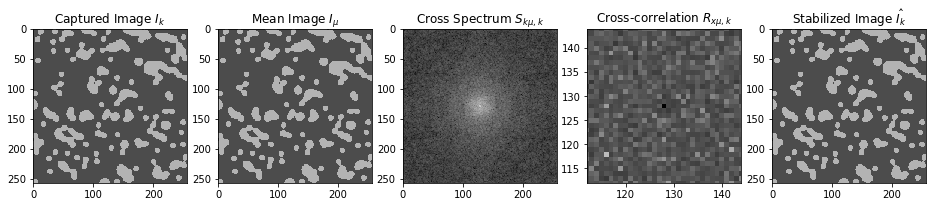

In [5]:
def plot_frame(frame):
    fig, ax = plt.subplots(ncols=5, figsize=(16,6))
    ax[0].imshow(frame['capture'], vmin=0, vmax=1)
    ax[0].set_title('Captured Image $I_k$')
    ax[1].imshow(frame['mu_image'], vmin=0, vmax=1)
    ax[1].set_title('Mean Image $I_\mu$')
    ax[2].imshow(fftshift(np.log(np.abs(frame['Sxm']))))
    ax[2].set_title('Cross Spectrum $S_{k\mu,k}$')
    ax[3].imshow(-np.log(np.abs(frame['Rxm'])))
    ax[3].axis([112,144,112,144])
    ax[3].set_title('Cross-correlation $R_{x\mu,k}$')
    ax[4].imshow(frame['stabilized'], vmin=0, vmax=1)
    ax[4].set_title('Stabilized Image $\hat{I_k}$')
    
image = SyntheticBlobs()
correction = MotionCorrect([image])
frame = next(correction)
plot_frame(frame)


### Automatic Tests

Encoding automatic versions of the above tests will enable developers to quickly test *all* assertions quickly with a single command or click whenever they want, especially immediately prior to commiting changes to revision control. These tests will also run automatically by continuous integration on every commit, including merges.

In [6]:
class SingleImageTests(unittest.TestCase):
    def setUp(self):
        self.image = SyntheticBlobs()
        correction = MotionCorrect([self.image])
        self.frame = next(correction)
        
    def test_mean_image(self):
        self.assertAlmostEqual(measure.compare_mse(self.image, frame['mu_image']), 0, msg='capture == mean image')

    @unittest.skip('not implemented')    
    def test_cross_spectrum(self):
        pass
        
    def test_cross_correlation(self):
        Rxm = self.frame['Rxm']
        N = self.image.shape[0]
        
        # Confirm this looks like a Kronecker delta with exactly one peak value, in the middle of the image
        peak_location = np.unravel_index(Rxm.argmax(), Rxm.shape)
        center_location = (int(N/2), int(N/2))
        self.assertEqual(peak_location, center_location, msg='Rxm peak at center')
        histogram, centers = exposure.histogram(Rxm, 4)
        self.assertListEqual(list(histogram), [N*N-1, 0, 0, 1], msg='Histogram mass all in zero bin except one')
        
    def test_stabilized_image(self):
        self.assertAlmostEqual(measure.compare_mse(self.image, frame['stabilized']), 0, msg='capture == stable image')
        
# This is actually easier from the command line or inside Jenkins than here in Jupyter
suite = unittest.TestLoader().loadTestsFromModule(SingleImageTests())
unittest.TextTestRunner().run(suite)

.s..
----------------------------------------------------------------------
Ran 4 tests in 0.514s

OK (skipped=1)


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

### Commit Changes

Now that a basic single image scenario is commited to source control, the tests will be run by continuous integration, every single time new code is committed in the future.  If new code ever violates the assumptions described above, the team will know about the breakage very quickly, without doing any work to find out.  In the meantime, new development can be much more aggressive, because engineers do not have to worry about breaking old stuff and not knowing that it happened.

## Synthetic Microscope Capture Model

Next we must exercise the algorithm much more rigorously with a lot more data, corrupted by nonzero shifts and noise.  For now, we model a linear translation warp, and random Gaussian noise.

Normally, I would write `simulate_capture()` as a generator to avoid needing the `length` parameter and to be efficient with memory usage.  Unfortunately, computing the mean image $I_\mu$ needs an entire epoch in advance, so the generator pattern offers no advantage here and every image must be stored at the same time.

The capture simulator is designed so the different distortion effects (warp and noise) are completely separated from each other.  This makes it easy to tweak the models with no disruption to the other modules.

In [7]:
def simulate_capture(image, drift, noise, length=16):
    transforms = [next(drift) for i in range(length)]
    imagelist = [transform.warp(image, T) for T in transforms]    
    imagelist = [noise(image) for image in imagelist]    
    return imagelist

###  Motion Model

This is still a simplified situation from the real world.  If we find a problem, we need the tests to make it easy to find the bug; hence, straight line motion is more useful at this stage than realistic motion patterns.  Knowing that a variety of tests are coming of varying complexity, here are a set of useful motion models implemented in a very modular, object oriented way.  Any of these generators inheriting `MotionModel` will emit a sequence of affine transforms as long as a test runner keeps calling them.  Notice that other aspects of our overall capture model, like noise and possibly nonlinear distortion, are kept separate, keeping the motion models clean, readable, and simple to modify.

In [8]:
class MotionModel:
    def __init__(self):
        self.track = [AffineTransform()]
        
    def __iter__(self):
        return self
    
    def __next__(self):
        xform = self.track[-1] + self.transform()
        self.track.append(xform)
        return xform

class NoDrift(MotionModel):
    def transform(self):
        return AffineTransform()
    
class HorizontalDrift(MotionModel):
    def transform(self):
        return AffineTransform(translation = [1,0])

class VerticalDrift(MotionModel):
    def transform(self):
        return AffineTransform(translation = [0,1]) 

class RandomWalk(MotionModel):
    def transform(self):
        T = np.random.choice(np.arange(-3,3,.1), size=2)
        return AffineTransform(translation=T)


### Noise Model

Similar to the motion model, we could have multiple noise types without touching any other part of the test code.

In [9]:
class WhiteNoise:
    def __init__(self, variance = 0.0):
        self.variance = variance 
        
    def __call__(self, image):
        return util.random_noise(image, var=self.variance)

### Manual Testing

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in log


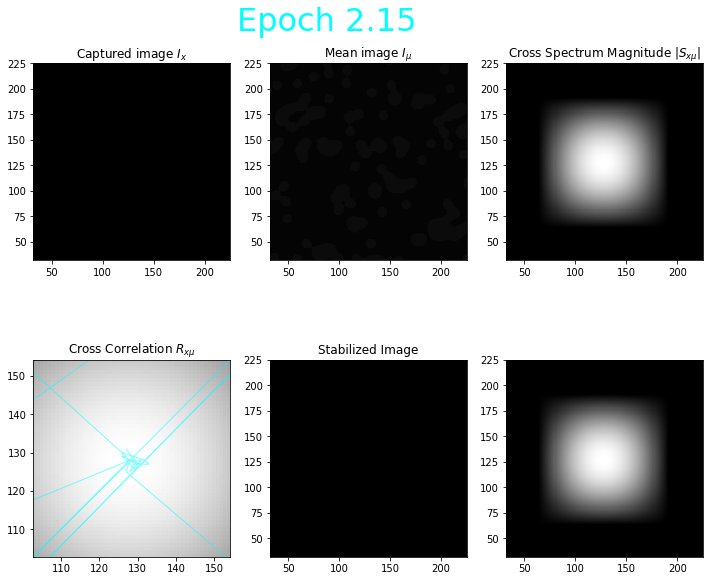

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12,10))
ax = axes.flatten()
pad = PaddedHanningWindow()  
image_artist = [a.imshow(pad, vmin=0, vmax=1) for a in ax]
image_artist[2] = ax[2].imshow(pad, vmin=0, vmax=30)
image_artist[3] = ax[3].imshow(pad, vmin=-10, vmax=0, zorder=0)
P=32
N = pad.shape[0]
for a in ax:
    a.axis([P,N-P,P,N-P])
ax[3].axis([N/2-N/10, N/2+N/10, N/2-N/10, N/2+N/10])

for a, title in zip(ax, ['Captured image $I_x$', 'Mean image $I_\mu$', 
                         'Cross Spectrum Magnitude $|S_{x\mu}|$', 
                         'Cross Correlation $R_{x\mu}$',
                         'Stabilized Image', '']):
    a.set_title(title)

text1 = ax[1].text(0, N, "Epoch 0", color='cyan', fontsize=32)
track, = ax[3].plot([], [], color='cyan', lw=1, alpha=.5, zorder=2)
truth, = ax[3].plot(
    [],
    # [pad.shape[0]/2 - x[0] -.5 for x in model.walk], [pad.shape[1]/2 - x[1] -.5 for x in model.walk], 
    color='red', zorder=1, lw=10, alpha=.5)

vmark = ax[3].axvline(N/2, color='yellow', linestyle=':', alpha=1)
hmark = ax[3].axhline(N/2, color='yellow', linestyle=':', alpha=1)

walk_x = []
walk_y = []

def animate(frame):
    # capture, epoch, mu_image, Sxm, Rxm, stabilized = data
    Rxm = frame['Rxm']
    for artist, img in zip(image_artist, 
            [frame['capture'], frame['mu_image'], fftshift(np.log(np.abs(frame['Sxm']))), np.log(Rxm), frame['stabilized'], pad]):
        artist.set_array(img)
    argmax = np.unravel_index(Rxm.argmax(), Rxm.shape)
    hmark.set_ydata([argmax[0]])
    vmark.set_xdata([argmax[1]])
    walk_x.append(argmax[0])
    walk_y.append(argmax[1])
    track.set_data(walk_y, walk_x)
    text1.set_text('Epoch {}.{}'.format(*frame['epoch']))
    return image_artist
    
imagelist = simulate_capture(SyntheticBlobs(), RandomWalk(), WhiteNoise(0.00001))
stabilized = MotionCorrect(imagelist)
anim = animation.FuncAnimation(fig, animate, frames=stabilized, blit=True)
anim

### Automatic Testing

# Exercising Real Data